# Minimax-optimal and Locally-adaptive Online Nonparametric Regression

This notebook contains code and numerical experiments illustrating the results in https://arxiv.org/pdf/2410.03363.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def data(x,L=1,b=0):
    """Target function"""
    return np.cos(10*L*(x+b)) - np.sin(5*L*(x+b)) + 5
    #return np.exp(-100*L*(x-0.5)**2) + np.exp(-50*L*(x-0.2)**2)

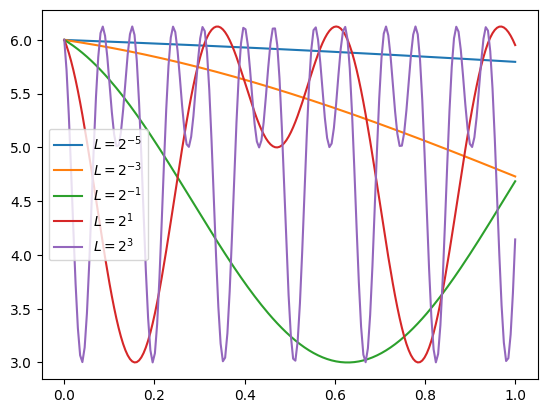

In [2]:
# Plot different target functions with L = 2**k

x = np.linspace(0,1,200).reshape(-1,1)
fig = plt.figure()
for k in range(-5,5,2):
  plt.plot(x,[data(xx,L=2**k) for xx in x],label=fr'$L=2^{{{k}}}$')
plt.legend();

# Training Chaining Tree and Locally Adaptive Online algorithms


In [3]:
# Import random library & models
import numpy.random as rd
from models import ChainingTree, Locally_Adaptive_Reg

# Data and parameters

N_sim = 5
Lip = np.linspace(2**(-6),2**5,20)
X = [[0.,1.]]
b = rd.uniform(0,1,N_sim)
dim = len(X)
T = 2000
loss = 'squared'
depth_chaining = 5
depth_core = 3

reg1 = np.zeros((N_sim,Lip.shape[0],T))
reg2 = np.zeros((N_sim,Lip.shape[0],T))
reg_0 = np.zeros((N_sim,Lip.shape[0],T))
c1 = np.zeros((N_sim,Lip.shape[0],2))
c2 = np.zeros((N_sim,Lip.shape[0],2))

data_save = []
l_f1 = []
l_f2 = []

for k in range(Lip.shape[0]):

  for l in range(N_sim):
    X_train = rd.uniform(X[0][0],X[0][1],(T,dim))
    sigma = 0.5
    noise = sigma * rd.normal(0,1,T)

    print(f'Exp n°{l+1}, L={15*Lip[k]}')

    y_train = np.array([data(x,L=Lip[k],b=b[l]) for x in X_train]).reshape(-1)
    y_train += noise

    f1 = ChainingTree(root=X, depth=depth_chaining, dim=dim)
    f2 = Locally_Adaptive_Reg(root=X, depth_core=depth_core, depth_chaining=depth_chaining, dim=dim)
    simu_chaining = f1.train(X_train = X_train, y_train = y_train, loss = loss, display=1000)
    simu_core_tree = f2.train(X_train = X_train, y_train = y_train, loss = loss, display=1000)

    if l == 0 :
      l_f1.append(f1)
      l_f2.append(f2)
      data_save.append((X_train,y_train))
    oracle = sigma * (2/np.pi) ** (1/2) * np.arange(1,T+1,1) if loss == 'absolute' else sigma ** 2 * np.arange(1,T+1,1)
    reg1[l,k,:] = np.cumsum(simu_chaining[0]) - oracle
    reg2[l,k,:] = np.cumsum(simu_core_tree[0]) - oracle
    reg_0[l,k,:] = np.cumsum(np.abs(y_train)) - oracle
    c1[l,k,:] = simu_chaining[1:]
    c2[l,k,:] = simu_core_tree[1:]

Exp n°1, L=0.234375
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°2, L=0.234375
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°3, L=0.234375
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°4, L=0.234375
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°5, L=0.234375
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°1, L=25.485197368421055
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°2, L=25.485197368421055
Start training Chaining Tree
	 Time: 0
	 Time: 1000
Start training Locally Adaptive Online Reg
	 Time: 0
	 Time: 1000
Exp n°3, L=25.

#XPs

Here are the results of experiments conducted in a simple regression setting for both the Chaining Tree method and Locally Adaptive Online Regression algorithm. Refer to Theorems 1 and 2 (and/or Corollary 1) in the paper.

*Key observations:*
- For the absolute loss case, $\ell_t(y) = |y - y_t|$, we observe that the Locally Adative Online algorithm reduces regret with respect to $L$ (achieving $O(\sqrt{L})$) while maintaining a time rate of $O(\sqrt{T})$.
- For the squared loss, $\ell_t(y) = (y - y_t)^2$, Locally Adaptive Online Regression achieves a time rate of $O(T^{\frac{1}{3}})$. However, the trade-off is an increased dependence on the smoothness $L$, shifting from $O(L^{\frac{1}{2}})$ to $O(L^{\frac{2}{3}})$.

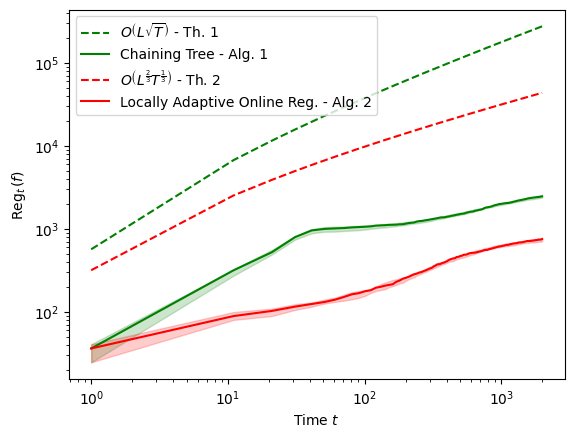

In [4]:
from scipy.stats.mstats import mquantiles

# Regret with respect to T (L fixed)

k = 2
step = 10
fig=plt.figure()

# Plot for Chaining Tree
quantiles = mquantiles(reg1[:,k,:], axis=0)
const1 = np.max(c1[:,k,:], axis=0)
plt.loglog(np.arange(1,T+1,step),const1[1]*(const1[0]+15*Lip[k]) * np.log(np.arange(1,T+1,step)+1) * np.sqrt(np.arange(1,T+1,step)),'g--',label=r'$O\left(L\sqrt{T}\right)$ - Th. 1') #Theory: G(B+L)log(T)sqrt(T)
plt.loglog(np.arange(1,T+1,step),quantiles[1][::step], 'g-', label='Chaining Tree - Alg. 1')
plt.fill_between(np.arange(1,T+1,step), np.array(quantiles[0][::step]), np.array(quantiles[2][::step]), color='green', alpha=.2)

# Plot for Locally Adaptive Online Regression
quantiles2 = mquantiles(reg2[:,k,:], axis=0)
const2 = np.max(c2[:,k,:], axis=0)
if loss == 'absolute':
  plt.loglog(np.arange(1,T+1,step),const2[1]*np.log(np.arange(1,T+1,step)+1)*np.sqrt(15*Lip[k]*np.arange(1,T+1,step)),'r--',label=r'$O\left(\sqrt{LT}\right)$ - Th. 2') #Theory: GBlog(T)sqrt(LT)
elif loss == 'squared' :
  plt.loglog(np.arange(1,T+1,step), const2[1]*np.log(np.arange(1,T+1,step)+1)*(15*Lip[k])**(2/3)*np.arange(1,T+1,step)**(1/3),'r--',label=r'$O\left(L^{\frac{2}{3}}T^{\frac{1}{3}}\right)$ - Th. 2')

plt.loglog(np.arange(1,T+1,step), quantiles2[1][::step], 'r-', label=r'Locally Adaptive Online Reg. - Alg. 2')
plt.fill_between(np.arange(1,T+1,step), np.array(quantiles2[0][::step]), np.array(quantiles2[2][::step]), color='red', alpha=.2)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$\operatorname{Reg}_t(f)$')
plt.legend(loc='best');

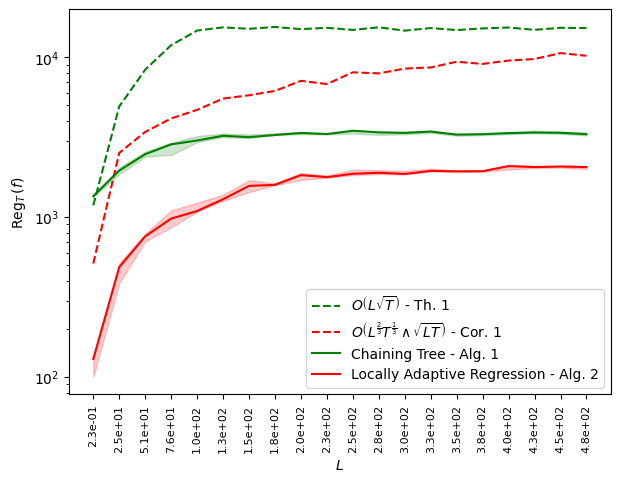

In [7]:
# Regret with respect to L (T fixed)

quantiles1 = mquantiles(reg1[:,:,-1], axis=0)
quantiles2 = mquantiles(reg2[:,:,-1], axis=0)
quantiles_0 = mquantiles(reg_0[:,:,-1], axis=0)
const1 = np.max(c1, axis=0)
const2 = np.max(c2, axis=0)

# Theory
plt.figure(figsize=(7,5))
plt.plot([min(0.03*const1[k,1]*(15*Lip[k]+8)*np.log(T)*np.sqrt(T),const1[k,0]*T-sigma**2*T) for k in range(Lip.shape[0])],'g--',label=r'$O\left(L\sqrt{T}\right)$ - Th. 1') #Theory: G(B+L)log(T)sqrt(T)
plt.plot([min(0.1*const1[k,1]*np.log(T)*np.sqrt((15*Lip[k]+1)*T),const1[k,1]*np.log(T)*(15*Lip[k])**(2/3)*T**(1/3),const1[k,0]*T-sigma**2*T) for k in range(Lip.shape[0])],'r--',label=r'$O\left(L^{\frac{2}{3}}T^\frac{1}{3} \wedge \sqrt{LT}\right)$ - Cor. 1')

# Plot the results for the Chaining Tree algorithm (Alg. 1)
plt.plot(range(Lip.shape[0]), quantiles1[1], 'g-', label='Chaining Tree - Alg. 1')
plt.fill_between(range(Lip.shape[0]), np.array(quantiles1[0]), np.array(quantiles1[2]), color='green', alpha=.2)

# Plot the results for the Locally Adaptive algorithm (Alg. 2)
plt.plot(range(Lip.shape[0]), quantiles2[1], 'r-', label='Locally Adaptive Regression - Alg. 2')
plt.fill_between(range(Lip.shape[0]), np.array(quantiles2[0]), np.array(quantiles2[2]), color='red', alpha=.2)

plt.xlabel(r'$L$')
plt.xticks(range(Lip.shape[0]), [np.format_float_scientific(15*num, precision=1) for num in Lip], fontsize=8, rotation=90)
plt.yscale('log')
#plt.ylim(4*1e2,)
plt.ylabel(r'$\operatorname{Reg}_T(f)$')
plt.legend(loc='best');

## Visualize predictions after time $T$

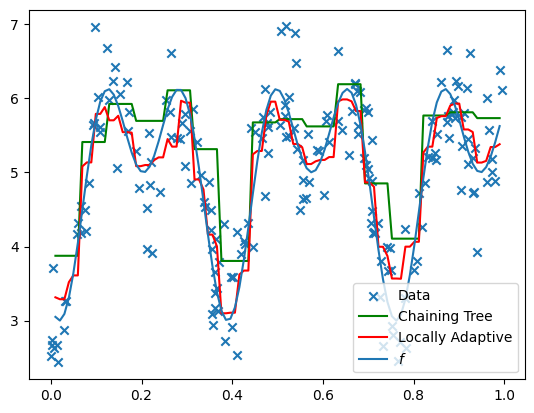

In [8]:
# Plot predictions

k=2 # Change k for over Lipschitz constant
x = np.linspace(X[0][0]+0.01, X[0][1]-0.01, 100).reshape(1,-1)
plt.scatter(data_save[k][0][::10], data_save[k][1][::10], marker= 'x', label=fr'Data')
plt.plot(x.reshape(-1), [l_f1[k].predict(x[:,t])[-1] for t in range(100)], c='g', label=r'Chaining Tree')
plt.plot(x.reshape(-1), [l_f2[k].predict(x[:,t])[-1] for t in range(100)], c='r', label=r'Locally Adaptive')
plt.plot(x.reshape(-1),[data(x[:,t],Lip[k],b[0]) for t in range(100)], label= fr'$f$')
plt.legend(loc='best');